In [1]:
import pandas as pd
import gensim
from gensim.models import Doc2Vec
import os

### Document Embedding

In [2]:
convert_data = pd.read_csv('converted.csv')

In [3]:
def train_data():
    train_document = []
    TaggededDocument=gensim.models.doc2vec.TaggedDocument
    for i in range(len(convert_data)):
        title = convert_data['Paper'][i]
        document = TaggededDocument(gensim.utils.simple_preprocess(title),tags=[i*2])
        train_document.append(document)

        discription = convert_data['Discription'][i]
        document = TaggededDocument(gensim.utils.simple_preprocess(discription),tags=[i*2+1])
        train_document.append(document)

    return train_document

In [4]:
if not os.path.exists('./models/d2v.model'):
    model = Doc2Vec(train_document, dm=1, vector_size=150, window=8, min_count=2, workers=4,iter=10)
    model.save('./models/d2v.model')
else:
    model = Doc2Vec.load('./models/d2v.model')

In [5]:
convert_data['PapaerAndDes'] = convert_data.apply(lambda x: x['Paper']+'. '+x['Discription'],axis=1)

### Attributed Node Embedding

In [6]:
import random
import numpy as np
import networkx as nx
from scipy.sparse import coo_matrix
from karateclub.node_embedding.attributed import SINE,ASNE


In [7]:
pd_graph = pd.read_csv('./EdMot/input/cora_edges.csv')
or_num = pd_graph['id_1'].to_list()
or_num.extend(pd_graph['id_2'].to_list())

In [8]:
or_num = list(set(or_num))
or_num.sort()
newnum_to_ornum= dict(zip(
list(range(len(or_num))),or_num
))
ornum_to_newnum = dict(zip(
or_num,list(range(len(or_num)))
))

In [9]:
import json

In [10]:
data = json.loads(json.dumps(newnum_to_ornum))
with open('./Embedding/newnum_to_ornum' ,'w') as f:
    json.dump(data,f)

data = json.loads(json.dumps(ornum_to_newnum))
with open('./Embedding/ornum_to_newnum' ,'w') as f:
    json.dump(data,f)

In [11]:
pd_graph['id_1'] = pd_graph['id_1'].apply(lambda x: ornum_to_newnum[x])
pd_graph['id_2'] = pd_graph['id_2'].apply(lambda x: ornum_to_newnum[x])

In [12]:
pd_graph.sort_values(by=['id_1'],ascending=True, inplace =True)

In [13]:
pd_graph.index = list(range(pd_graph.shape[0]))

In [14]:
g = nx.from_edgelist(pd_graph.values.tolist())

In [15]:
col = np.array([])
row = np.array([])

In [16]:
for node in g.nodes():
    
    doc_ofnode = convert_data.loc[convert_data['author_num_list'].apply(lambda x : str(newnum_to_ornum[node]) in x),'PapaerAndDes']
    
    doc = []
    for i in doc_ofnode:
        split_text=i.split('.')
        doc.extend(split_text)
    row = np.append(row,[node]*150)
    col = np.append(col,model.infer_vector(doc))
    
    

In [17]:
g.number_of_nodes()

756

In [18]:
data = np.ones(len(g.nodes())*150)
shape = (len(g.nodes()), 150)

X = coo_matrix((data, (row, col)), shape=shape)

model_node_embedding = SINE(dimensions=10,
                 epochs=10,
                 learning_rate=0.01)

model_node_embedding.fit(g, X)

In [19]:
node_vector=model_node_embedding.get_embedding()

In [20]:
from sklearn.cluster import k_means
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap,SpectralEmbedding
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [64]:
cluster_res = k_means(node_vector,n_clusters=4,random_state=5)
cluster_res = cluster_res[1]

In [65]:
se = SpectralEmbedding(n_components=3,random_state=3)

In [66]:
iso_vector=se.fit_transform(node_vector)

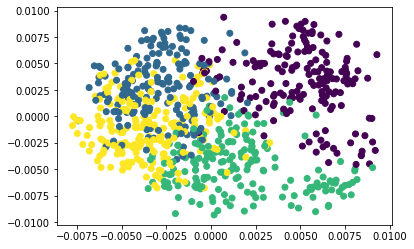

In [67]:
plt.scatter(iso_vector[:, 0], iso_vector[:, 1], c=cluster_res)

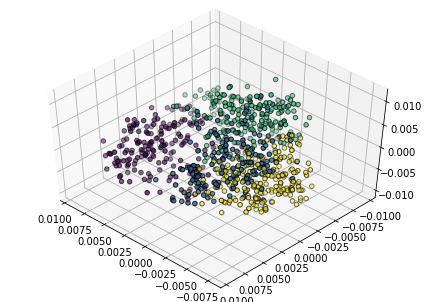

In [68]:
fig = plt.figure(1)

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(iso_vector[:, 0], iso_vector[:, 1], iso_vector[:, 2],
               c=cluster_res, edgecolor='k')

In [69]:
cluster_output = {}
for i,v in enumerate(list(g.nodes())):
    cluster_output[newnum_to_ornum[v]] = int(cluster_res[i])

In [70]:
data = json.loads(json.dumps(cluster_output))
with open('./EdMot/output/ContentBasedClustering.json' ,'w') as f:
    json.dump(data,f)
